In [47]:
from collections import namedtuple

import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from kmodes.kmodes import KModes

%matplotlib inline

In [85]:
Summary = namedtuple(
    "Summary",
    ["name", "num_rows", "num_cols", "num_classes", "missing_values", "duplicate_rows", "adjusted_num_rows"]
)

summaries = []
for dataset_name in ("breast_cancer", "mushroom", "soybean", "zoo"):

    df = pd.read_csv(f"../data/{dataset_name}.csv", na_values=["?", "dna"])
    
    classes = df["class"]
    df = df.drop("class", axis=1)

    dropped_df = df.dropna()
    missing_values = len(dropped_df) != len(df)
    dropped_df = dropped_df.drop_duplicates()
    duplicate_rows = len(dropped_df) != len(df)

    nrows, ncols = df.shape
    nclasses = classes.nunique()
    adjusted_nrows = len(dropped_df)
    
    summaries.append(
        Summary(
            dataset_name, nrows, ncols, nclasses, missing_values, duplicate_rows, adjusted_nrows
        )
    )


In [86]:
summary_df = pd.DataFrame(summaries).set_index("name")
summary_df.index = [" ".join(name.split("_")).capitalize() for name in summary_df.index]
summary_df.columns = [" ".join(col.replace("num", "no.").split("_")).capitalize() for col in summary_df.columns]

summary_df.to_latex("../tex/dataset_summary.tex")
summary_df

,No. rows,No. cols,No. classes,Missing values,Duplicate rows,Adjusted no. rows
Breast cancer,699,9,2,True,True,449
Mushroom,8124,22,2,True,True,5644
Soybean,307,35,19,True,True,263
Zoo,101,17,7,False,False,101


In [87]:
dataset_costs = {}
for dataset_name in ("breast_cancer", "mushroom", "soybean", "zoo"):

    df = pd.read_csv(f"../data/{dataset_name}.csv", na_values=["?", "dna"])
    df = df.drop("class", axis=1).dropna().drop_duplicates()

    costs = []
    for k in tqdm.tqdm(range(2, 16)):
        km = KModes(n_clusters=k, init="random", n_init=10, random_state=0, n_jobs=1).fit(df)
        costs.append(km.cost_)

    dataset_costs[dataset_name] = costs



100%|██████████| 14/14 [00:10<00:00,  1.31it/s]

100%|██████████| 14/14 [03:20<00:00, 14.33s/it]

100%|██████████| 14/14 [00:14<00:00,  1.06s/it]

100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


RuntimeError: In set_text: could not load glyph

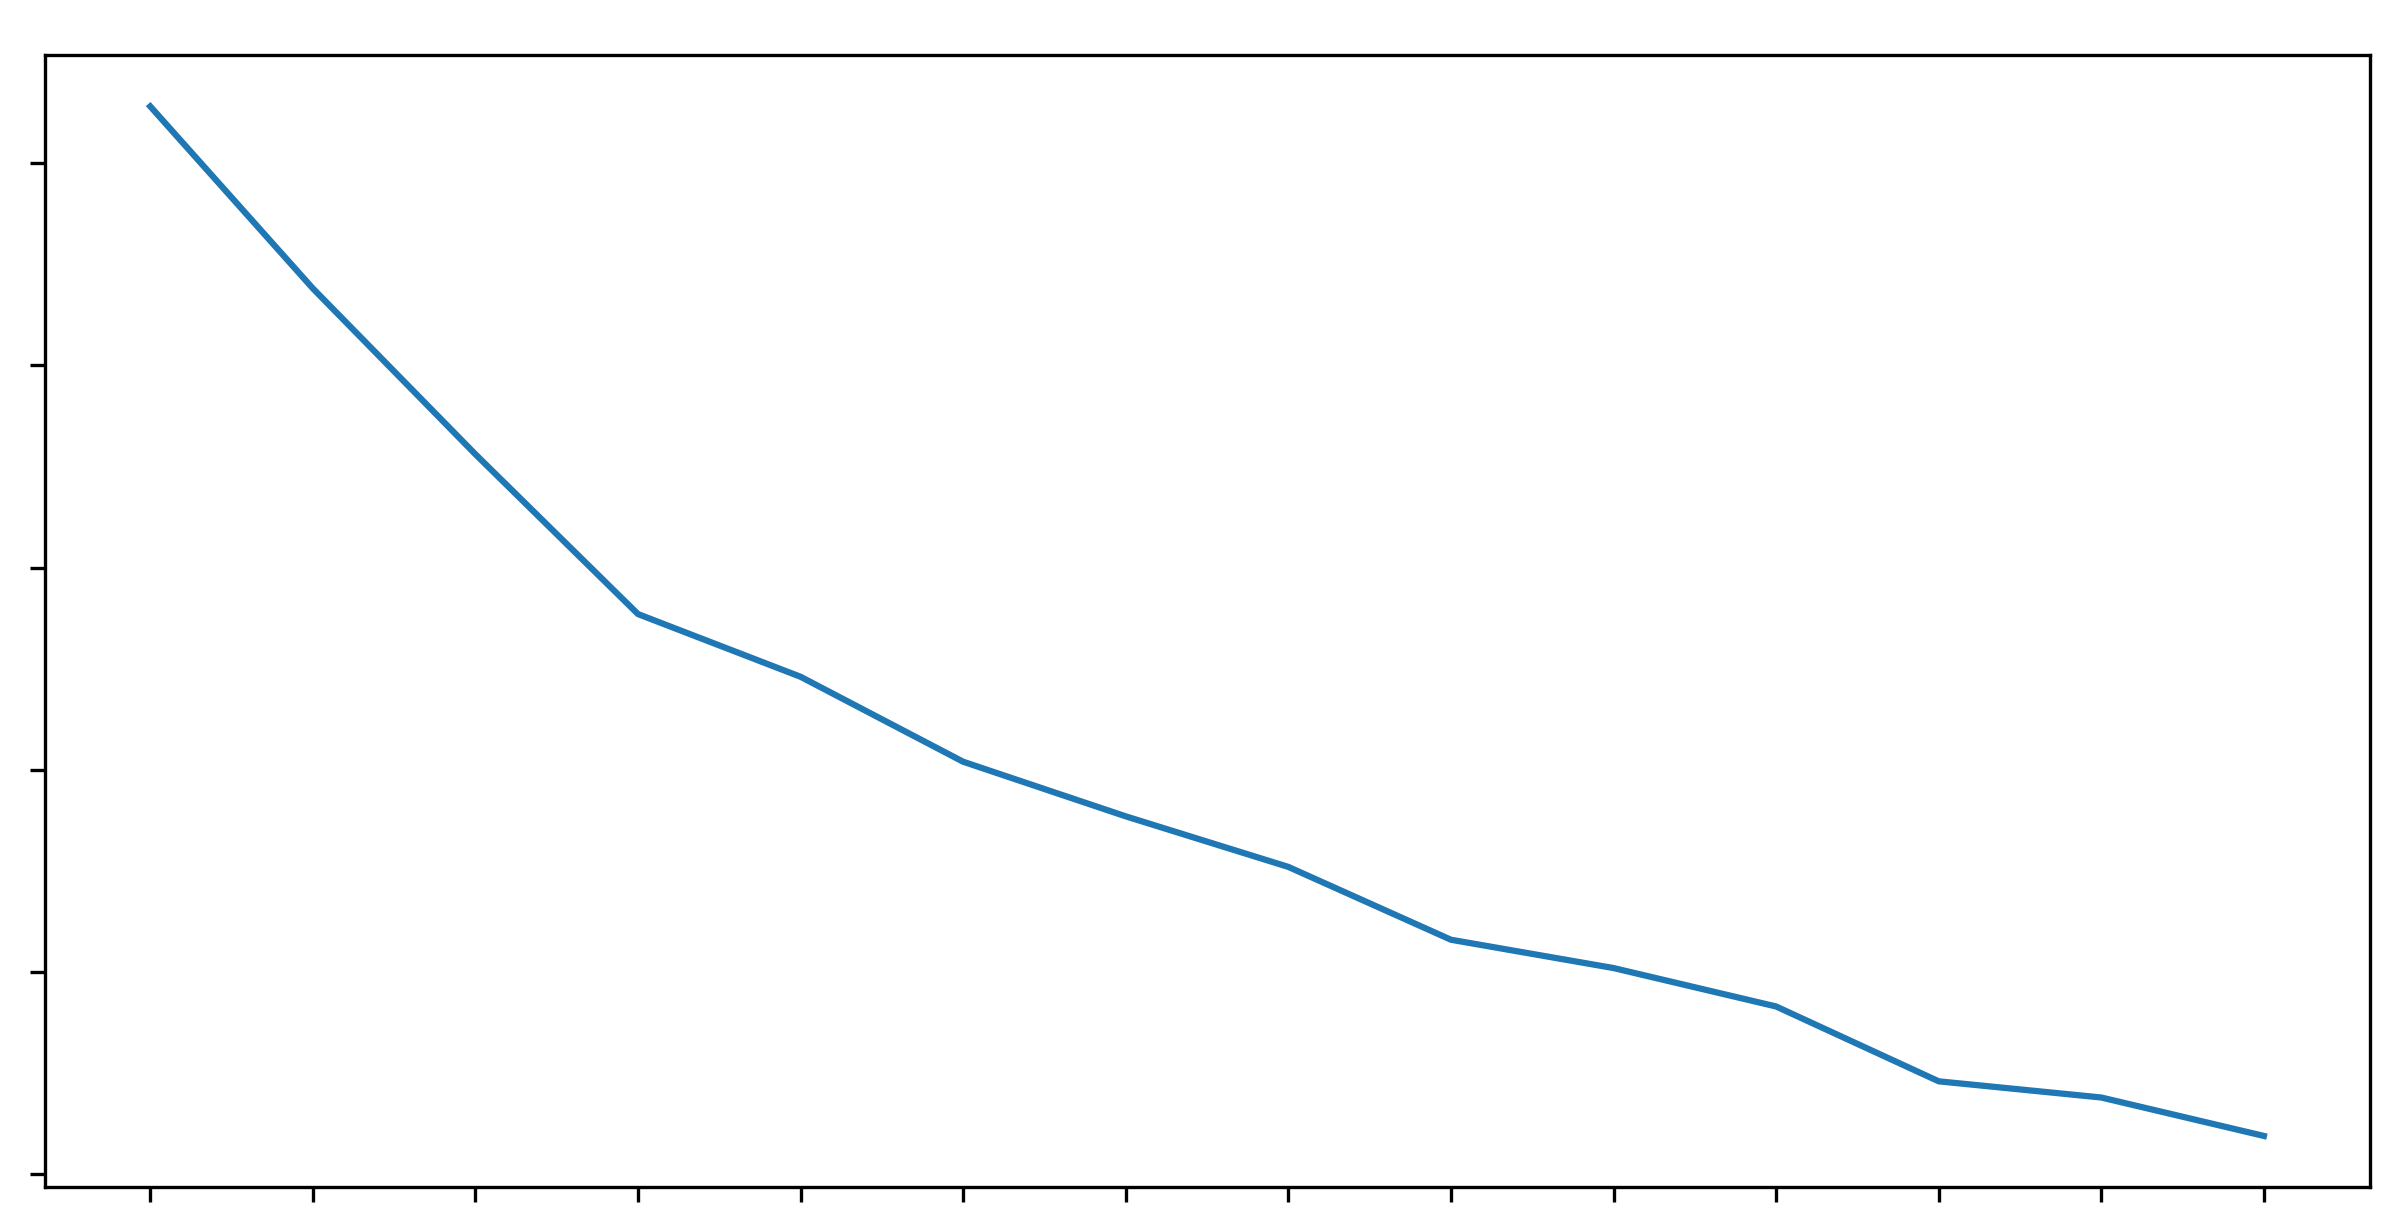

In [88]:
for dataset_name, costs in dataset_costs.items():

    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

    ax.plot(costs)

    ax.set_xticks(range(14))
    ax.set_xticklabels(range(2, 16))
    ax.set_xlabel("n_clusters")
    ax.set_ylabel("cost")

    title_name = " ".join(dataset_name.split("_"))
    ax.set_title(f"Elbow plot for {title_name} dataset")

    plt.savefig(f"../img/{dataset_name}_elbowplot.pdf", transparent=True)